In [1]:
# Libs necessárias
import random
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import joblib

# Libs gráficas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# ML Preprocessing
import category_encoders as ce
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.compose import ColumnTransformer

# ML Models
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

# ML Metrics
from sklearn.metrics import silhouette_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\Daniel\Documents\Segmentacao_Clientes\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Lendo os dados
endereco = pd.read_excel(r'C:\Users\Daniel\Documents\Segmentacao_Clientes\data\raw\CustomerAddress.xlsx', header = 1)
demografia = pd.read_excel(r'C:\Users\Daniel\Documents\Segmentacao_Clientes\data\raw\CustomerDemographic.xlsx', header = 1)
transacoes = pd.read_excel(r'C:\Users\Daniel\Documents\Segmentacao_Clientes\data\raw\Transactions.xlsx', header = 1)
novos_clientes = pd.read_excel(r'C:\Users\Daniel\Documents\Segmentacao_Clientes\data\raw\New_Customers.xlsx', header = 1)

In [3]:
# Unindo as tabelas
df_final = endereco.merge(demografia, how = 'inner', on = 'customer_id')
df_final = transacoes.merge(df_final, how = 'inner', on = 'customer_id')

In [4]:
# Droppando uma coluna 
df_final.drop(columns = 'default', inplace = True)

In [5]:
# Salvando os dados após o JOIN
df_final.to_excel('joined_dataset.xlsx')

#### Relatório do Dataset

In [6]:
# Criando um relatório geral e exportando para um arquivo html
relatorio = ProfileReport(df_final, 'Relatório Geral df_final')
relatorio.to_file('relatorio_profiling.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 283.59it/s]


##### Keypoints do relatório:
- Apesar de possuir 19968 registros, há apenas 3489 clientes únicos
- Algumas colunas categóricas possuem uma alta cardinalidade, ou seja, caso transformadas usando o OneHotEncoding, o número de colunas finais ficaria alto.
- Cerca de 1,5% das celúlas apresentam missing (att: células e registros(linhas) são diferentes).
- A coluna state possui valores iguais representados por nomes diferentes, como o Estado de Victoria sendo representado também pelo nome VIC.
- A coluna gender possui valores iguais representados por nomes diferentes, como o gênero Female sendo representado por F e Femal.
- A coluna DOB possui valores inseridos de forma errônea, onde consta que há clientes que nasceram no ano de 1843
- O Produto de ID 0 possui uma grande diferença de vendas em relação aos outros produtos. Ou de fato se trata do mesmo produto, ou há produtos diferentes que receberam o ID 0, algo que é possível pelo fato do produto possuir uma versão em cada brand, possuir dois tipos diferentes de linhas, possuir uma versão em todas as classes e em todos os tamanhos. 

In [7]:
# Verificando as colunas
df_final.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure'],
      dtype='object')

In [8]:
# Verificando as colunas
novos_clientes.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value'],
      dtype='object')

É notável que os dois datasets compartilham algumas colunas e outras não, portanto, focarei em corrigir inconsistências nos dados e tratar alguns valores nulos nas colunas presentes em ambos os datasets, pois os dados que serão segmentados (novos_clientes) precisam ter as mesmas colunas que serão usadas para treinar o modelo para que a previsão seja possível.

#### Análise exploratória:

Como o Dataset possui mais de um registro para o mesmo cliente, será necessário dropar itens duplicados em alguns casos, pois valores duplicados distorceriam a análise.

In [9]:
# Calculando a idade 
df_final['Age'] = 2022 - df_final.DOB.dt.year

In [10]:
# Criando uma lista com os indexes não duplicados
nodupli = df_final.customer_id.drop_duplicates().index.to_list()

In [11]:
# Criando um novo dataset
frame = df_final.loc[nodupli, ['Age', 'past_3_years_bike_related_purchases']]

Text(0.5, 0, 'Idade')

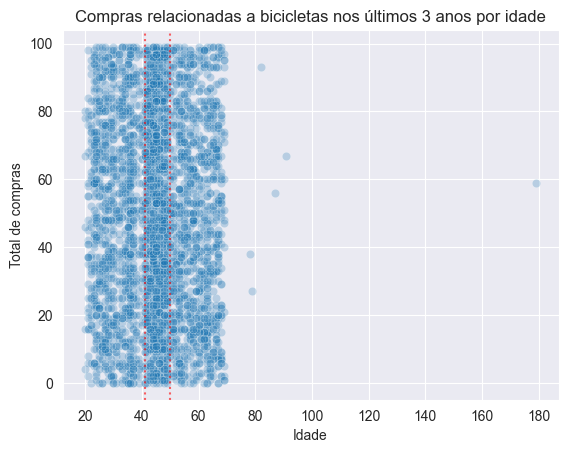

In [12]:
# Plotango um gráfico
sns.scatterplot(data = frame, 
                x = 'Age', 
                y = 'past_3_years_bike_related_purchases',
                alpha = 0.25)
plt.axvline(41, color = 'red', alpha = 0.60, ls = ':')
plt.axvline(50, color = 'red', alpha = 0.60, ls = ':')
plt.title('Compras relacionadas a bicicletas nos últimos 3 anos por idade')
plt.ylabel('Total de compras')
plt.xlabel('Idade')

<i>Reduzindo o valor do parâmetro alpha torna a densidade de pontos neste range da idade mais visível</i>
 - Podemos perceber um volume maior de compras entre pessoas com idade entre 41 a 50 anos.

In [13]:
# Criando um novo dataset
frame2 = df_final.loc[nodupli, ['job_industry_category', 
                                'past_3_years_bike_related_purchases']]
frame2 = frame2.groupby('job_industry_category')\
    .past_3_years_bike_related_purchases.sum().to_frame()
frame2.reset_index(inplace = True)

Text(0.5, 0, 'Segmento')

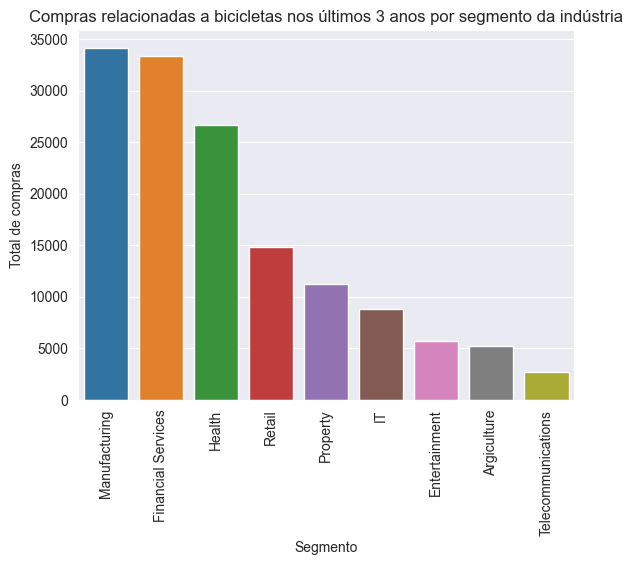

In [14]:
# Plotando o gráfico
sns.barplot(data = frame2,
            x = 'job_industry_category',
            y = 'past_3_years_bike_related_purchases',
            order = frame2.sort_values('past_3_years_bike_related_purchases',
                                       ascending = False).job_industry_category,
            errorbar = None)
plt.title('Compras relacionadas a bicicletas nos últimos 3 anos por segmento da indústria')
plt.xticks(rotation = 90)
plt.ylabel('Total de compras')
plt.xlabel('Segmento')

- O setor de manufatura, seguido pelo de serviços financeiros são onde estão os clientes que mais compraram produtos de ciclismo nos ultimos 3 anos.
- A quantidade de compras nesses dois setores somados representam 47% de todas as vendas nos ultimos 3 anos
- Se levar em consideração o setor da saúde, o terceiro maior, a representação passa a ser de 66% no número total de vendas

In [15]:
# Criando um Dataset
frame3 = df_final.loc[nodupli, ['state', 
                                'past_3_years_bike_related_purchases']]
frame3 = frame3.groupby('state')\
    .past_3_years_bike_related_purchases.sum().to_frame()
frame3.reset_index(inplace = True)

Text(0.5, 0, 'Estado')

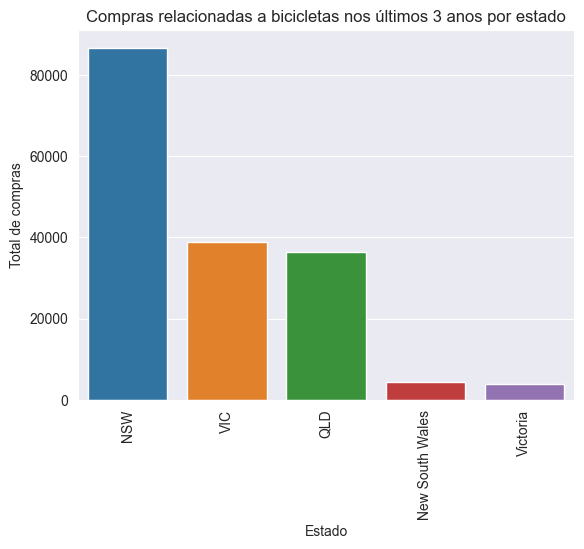

In [16]:
# Plotando o gráfico
sns.barplot(data = frame3,
            x = 'state',
            y = 'past_3_years_bike_related_purchases',
            order = frame3.sort_values('past_3_years_bike_related_purchases',
                                       ascending = False).state,
            errorbar = None)
plt.title('Compras relacionadas a bicicletas nos últimos 3 anos por estado')
plt.xticks(rotation = 90)
plt.ylabel('Total de compras')
plt.xlabel('Estado')

<i>Há estados de mesmo nome, mas representados de formas diferentes, para os insights serão levados em consideração a soma dos mesmos com suas respectivas categorias</i>

 - O estado de New South Wales é onde 53% de todas as vendas ocorreram nos últimos 3 anos
 - As vendas em New South Wales é 15% maior do que a dos outros estados somados

In [17]:
frame4 = df_final.brand.value_counts().to_frame()
frame4.reset_index(inplace = True)
frame4.rename(columns = {'brand':'qtd_vendas',
                         'index':'brand'},
              inplace = True)

Text(0.5, 0, 'Marca')

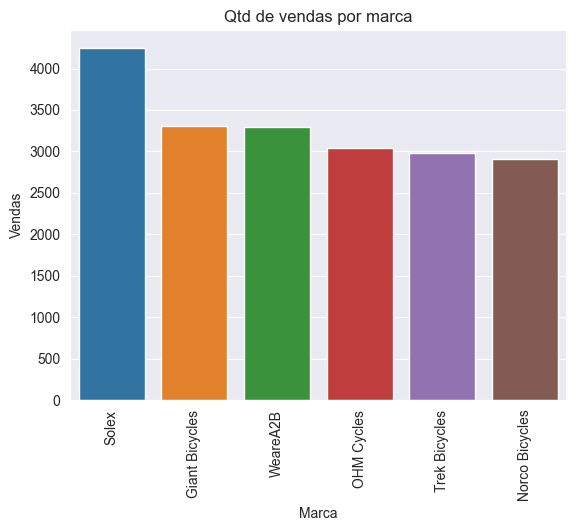

In [18]:
sns.barplot(data = frame4,
            x = 'brand',
            y = 'qtd_vendas')
plt.title('Qtd de vendas por marca')
plt.xticks(rotation = 90)
plt.ylabel('Vendas')
plt.xlabel('Marca')

 - A marca Solex vende em média 36% a mais do que as outras


#### Corrigindo inconsistências:

In [19]:
# Verificando os valores 
df_final.gender.value_counts()

Female    9979
Male      9510
U          455
F           11
Femal        7
M            6
Name: gender, dtype: int64

In [20]:
# Dicionário para transformar os dados
mapa_gender = {'Female':'F',
        'Male':'M',
        'F':'F',
        'Femal':'F',
        'M':'M',
        'U':'U'}

In [21]:
# Substituindo os valores
df_final['gender'] = df_final.gender.map(mapa_gender)

In [22]:
# Verificando os valores da coluna gender
df_final.gender.value_counts()

F    9997
M    9516
U     455
Name: gender, dtype: int64

Considerando apenas os indivíduos com sexo entre masculino e feminino, o feminino corresponde a 51%, enquanto o masculino a 49% 

In [23]:
# Verificando os nomes com gênero U
nomes = df_final[df_final.gender == 'U']['first_name'].unique().tolist()

In [24]:
# Selecionando aleatoriamente 39 nomes (51%)
random.seed(20)
sample_f = random.sample(nomes, 39)


In [25]:
# Criando uma função para alterar os dados
func = lambda x: 'F' if (x in sample_f) else 'M'

In [26]:
# Selecionando os indexes que possuem o gênero como 'U'
indexes = df_final[df_final.gender == 'U'].index.to_list()

In [27]:
# Corrigindo os registros com gender 'U'
df_final.loc[indexes, 'gender'] = df_final.loc[indexes, 
                                               'first_name'].apply(func)

In [28]:
# Verificando os valores da coluna state
df_final.state.value_counts()

NSW                10200
VIC                 4541
QLD                 4262
New South Wales      485
Victoria             480
Name: state, dtype: int64

In [29]:
# Criando a correção para a coluna state
mapa = {'NSW':'New South Wales',
        'VIC':'Victoria',
        'QLD':'Queensland',
        'New South Wales':'New South Wales',
        'Victoria':'Victoria'}

In [30]:
# Corrigindo os dados da coluna
df_final['state'] = df_final.state.map(mapa)

In [31]:
# Transformando o tipo de dado da coluna
df_final['DOB'] = pd.to_datetime(df_final.DOB)

In [32]:
# Podemos verificar que há um cliente cujo ano de nascimento consta como 1843
df_final[df_final.DOB.dt.year < 1900]['DOB']

5894   1843-12-21
5895   1843-12-21
5896   1843-12-21
5897   1843-12-21
5898   1843-12-21
5899   1843-12-21
5900   1843-12-21
5901   1843-12-21
5902   1843-12-21
Name: DOB, dtype: datetime64[ns]

In [33]:
# Obtendo os indexes dos registros com a inconsistência
indexes = df_final[df_final.DOB.dt.year < 1900].index.to_list()

In [34]:
# Alterando a data de nascimento para a mais provável
df_final.loc[indexes,'DOB'] = pd.to_datetime('1943-12-21')

#### Corrigindo valores missing:

Como a data de aniversário é um dado que não se consegue inputando a média ou mediana, os valores nulos dessa coluna serão excluídos

In [35]:
# Dropando os missings da coluna
df_final.dropna(subset = 'DOB', inplace = True)

In [36]:
# Verificando os missings
df_final.isna().sum()

transaction_id                            0
product_id                                0
customer_id                               0
transaction_date                          0
online_order                            351
order_status                              0
brand                                   187
product_line                            187
product_class                           187
product_size                            187
list_price                                0
standard_cost                           187
product_first_sold_date                 187
address                                   0
postcode                                  0
state                                     0
country                                   0
property_valuation                        0
first_name                                0
last_name                               626
gender                                    0
past_3_years_bike_related_purchases       0
DOB                             

Podemos perceber que algumas colunas (brand, product_line, product_class, etc) possuem o mesmo número de missing, o que pode indicar que os valores faltantes nessas colunas estão nos mesmos registros. A abordagem será dropar tais registros, pois os mesmos representam menos de 1% dos dados totais. Em relação a coluna online_order, os valores nulos serão preenchidos mantendo a mesma distribuição dos valores não nulos (aproximadamente 49% de valores 0 e 51% de valores 1). A coluna last_name será excluída, pois a identificação do cliente pode ser feita pelo ID, além disso, a coluna job_title e job_industry_category também serão excluídas por apresentarem um número alto de missings e por eu ter optado não utiliza-las no treino do modelo.

In [37]:
# Dropando os registros com menos de 1% de missings 
df_final.dropna(subset = 'brand', inplace = True)

In [38]:
# Armazenando os indexes dos registros com nulos
lista_nulos = df_final[df_final.online_order.isna()].index.to_list()

Seguindo a distribuição atual dos valores, ficará 173 registros com 1.0 e 166 com 0.0

In [39]:
# Selecionando 173 indexes de forma aleatória
random.seed(20)
indexes_um = random.sample(lista_nulos, 173)

In [40]:
# Alterando o valor dos nulos para 1.0
df_final.loc[indexes_um, 'online_order'] = 1.0

In [41]:
# Alterando os valores para 0.0
df_final.online_order.fillna(0.0, inplace = True)

#### Criando novas features:

In [42]:
# Calculando o total gasto por cada cliente
df_consumo_total = df_final.groupby('customer_id')\
    ['standard_cost'].sum().to_frame()

# Renomenado a coluna
df_consumo_total.rename(columns = {'standard_cost':'standard_cost_total'}, 
                        inplace = True)

# Juntando os datasets
df_final = df_final.merge(df_consumo_total, how = 'inner', on = 'customer_id')

In [43]:
# Criando nova feature
df_final['class_spend'] = pd.cut(df_final.past_3_years_bike_related_purchases, 
                                 bins = [-1, 30, 60, 100],
                                 labels = ['small', 'medium', 'high'])

In [44]:
# Criando nova feature
func = lambda x: 0 if (x <= 3) else 1
df_final['actual_work_last_3_y'] = df_final.tenure.apply(func)

#### Agrupando por ID:

In [45]:
# Verificando a quantidade de clientes unicos
len(df_final.customer_id.unique())

3413

In [46]:
# Verificando o tamanho do dataset
df_final.shape

(19335, 33)

Embora haja 19335 registros no dataset, há apenas 3413 clientes únicos, ou seja, vários registros se referem ao mesmo cliente. Para o agrupamento dos mesmos, dados referentes ao cliente e ao seu comportamente em relação as compras serão agrupados por ID de cada consmidor, e posteriormente, realizada a clusterização. Isso será feito para evitar que a mesma pessoa seja alocada em clusters diferentes devido aos múltiplos registros que ela possui.

In [50]:
# Dividindo as colunas por tipo
colunas_num = ['property_valuation', 'tenure',
               'actual_work_last_3_y', 'past_3_years_bike_related_purchases', 
               'customer_id']
colunas_cat = ['state', 'gender', 'class_spend',
           'deceased_indicator', 'customer_id']

In [51]:
# Guardando em um novo df as colunas com valores numéricos
df_num = df_final.loc[:, colunas_num].groupby('customer_id').median()

In [52]:
# Unindo os dataframes numéricos com as colunas categóricas
df_segmentation = df_num.merge(df_final.loc[:, colunas_cat],
                               on = 'customer_id',
                               how = 'left')

In [53]:
# Excluindo os valores duplicados
df_segmentation.drop_duplicates(inplace = True)

#### Construindo o modelo:

Para a avaliação do modelo, será levado em consideração a Silhouette Score, onde temos que:

O valor de Silhouette Score varia de -1 a 1. Se o score for próximo de 1, mais perfeita é a separação dos pontos entre os clusters. Caso seja mais próximo de 0, significa que os clusters podem estar sobrepostos, havendo pontos próximos do limite de decisão do algorítimo, quase sendo atribuídos a outros clusters. Já com um score próximo a -1, significa que há pontos que podem ter sido atribuídos a clusters diferentes do verdadeiro.

O que busco é um número de K onde o valor da Silhouette Score seja a maior possível, pois a seleção dos 1000 clientes será feita com base nos clusters, e é importante que cada cliente esteja alocado no cluster certo.

In [54]:
# Dropando o ID
segmentation = df_segmentation.drop(columns = 'customer_id')

In [55]:
# Inicializando os transformadores
encoder = OneHotEncoder(drop = 'first')
norm = Normalizer()

In [56]:
# Separando as colunas por tipo
num = segmentation.select_dtypes(['int64', 'float64']).columns
cat = segmentation.select_dtypes(['object', 'category']).columns

In [57]:
# Construindo um transformador
ct = ColumnTransformer(transformers = [('norm', norm, num),
                                       ('coder', encoder, cat)])

In [58]:
# Transformando os dados
dados_Kmeans = ct.fit_transform(segmentation)

In [59]:
# Testando números de clusters diferentes
dic_scores = {} 
for num in range(2, 10):
    modelo = KMeans(n_clusters = num, random_state = 16)
    labels = modelo.fit_predict(dados_Kmeans)
    dic_scores[num] = silhouette_score(dados_Kmeans, labels)

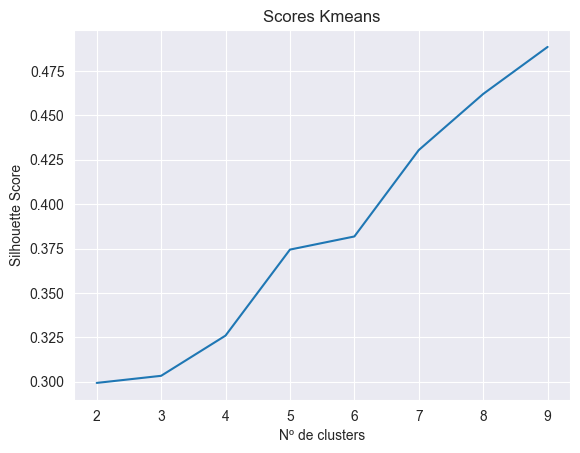

In [60]:
# Visualizando os scores
sns.lineplot(dic_scores)
plt.title('Scores Kmeans')
plt.xlabel('Nº de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [61]:
# Buscando os indexes das colunas categóricas
cat = segmentation.select_dtypes(['object', 'category']).columns.to_list()
indexes = []
for col in cat:
    indexes.append(segmentation.columns.get_loc(col)) 

In [62]:
# Aplicando encoding nas variáveis categóricas
to_silhouete = ce.OneHotEncoder().fit_transform(segmentation)

In [63]:
# Testando números de clusters diferentes
dic_scores = {} 
for num in range(2, 10):
    modelo = KPrototypes(n_init = 1, n_clusters = num, random_state = 16)
    labels = modelo.fit_predict(segmentation.to_numpy(), categorical = indexes)
    dic_scores[num] = silhouette_score(to_silhouete, labels)

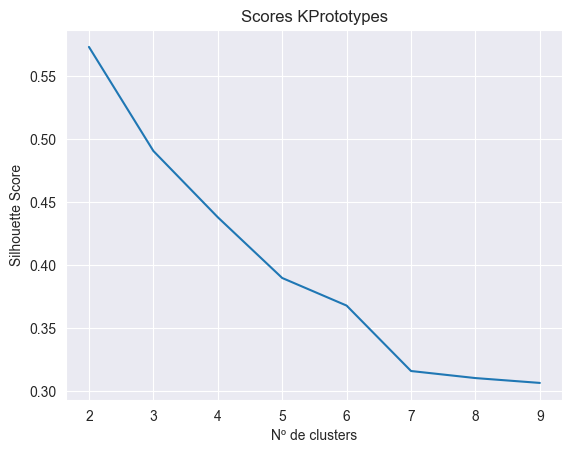

In [64]:
# Verificando os scores
sns.lineplot(dic_scores)
plt.title('Scores KPrototypes')
plt.xlabel('Nº de clusters')
plt.ylabel('Silhouette Score')
plt.show()

O K-Protypes consegue um resultado OK com um número de clusters menor que o K-Means. A tendência do K-Means é de crescimento, mas para chegar a uma boa Silhouette Score, seria necessário um grande número de clusters, o que dificultaria uma análise posterior.

In [65]:
# Criando o modelo
modelo = KPrototypes(n_init = 1, n_clusters = 2, random_state = 16)

In [66]:
# Armazenando as labels 
labels = modelo.fit_predict(segmentation.to_numpy(), categorical = indexes)

In [67]:
# Adicionando as labels no dataset
df_segmentation['label'] = labels

In [68]:
# Verificando a quantidade de compras por grupo
df_segmentation.groupby('label')['past_3_years_bike_related_purchases'].sum()

label
0    122071.0
1     45080.0
Name: past_3_years_bike_related_purchases, dtype: float64

In [70]:
# Adicionando o gasto total de cada cliente
df_segmentation = df_segmentation.merge(df_final.loc[:, 
                                                     ['customer_id', 
                                                      'standard_cost_total']], 
                                        how = 'inner', 
                                        on = 'customer_id').drop_duplicates()

Conclusão: Com uma quantidade de vendas 170% maior e uma quantidade de custos de fabricação de itens 10% menor, o cluster 0 mostrou ser o melhor.

In [71]:
# Recalculando a idade 
df_final['Age'] = 2022 - df_final.DOB.dt.year

In [72]:
# Separando colunas extras para adicionar ao df p/ PBI
df_extra = df_final.loc[:, ['customer_id', 'job_industry_category', 'Age']]
df_extra.drop_duplicates(inplace = True)

In [73]:
# Adicionando algumas colunas para análise no PBI
df_segmentation = df_segmentation.merge(df_extra, 
                                        how = 'left',
                                        on = 'customer_id')

In [74]:
# Melhorando a interpretabilidade do resultado
df_segmentation['label'] = df_segmentation.label.map({0:'Alto',
                                                      1:'Baixo'})
df_segmentation.rename(columns = {'label':'potencial_de_retorno'},
                       inplace = True)

In [75]:
# Exportando os dados
df_segmentation.to_excel('dadoscompras_to_pbi.xlsx')

In [77]:
# Salvando o modelo
joblib.dump(modelo, 'model_segmentation.pkl')

['model_segmentation.pkl']

#### Segmentando os potenciais clientes:

In [144]:
# Verificando inconsistências
print('Gênero', '\n', novos_clientes.gender.value_counts(), '\n')
print('Estado', '\n', novos_clientes.state.value_counts())


Gênero 
 Female    513
Male      470
U          17
Name: gender, dtype: int64 

Estado 
 NSW    506
VIC    266
QLD    228
Name: state, dtype: int64


As mesmas inconsistências encontradas no dataset de treino se repetem 

Em relação a coluna de gênero, com os registros de valor U, adotarei a mesma estratégia de tratamenta dessa variável no dataset de treino, onde mantive a mesma proporção entre F(52%) e M(48%).

In [145]:
# Criando um dic com os valores a serem alterados
mapa_state = {'NSW':'New South Wales',
              'VIC':'Victoria',
              'QLD':'Queensland',}
# Corrigindo os valores da coluna state
novos_clientes['state'] = novos_clientes.state.map(mapa_state)

In [146]:
# Verificando os nomes com gênero U
nomes = novos_clientes[
    novos_clientes.gender == 'U']['first_name'].unique().tolist()

# Selecionando aleatoriamente 39 nomes (51%)
random.seed(20)
sample_nomes = random.sample(nomes, 9)

# Criando uma função para alterar os dados
func = lambda x: 'F' if (x in sample_nomes) else 'M'

# Selecionando os indexes que possuem o gênero como 'U'
indexes = novos_clientes[novos_clientes.gender == 'U'].index.to_list()

# Corrigindo os registros com gender 'U'
novos_clientes.loc[indexes, 'gender'] = novos_clientes.loc[
    indexes, 
    'first_name'].apply(func)

# Criando um dic com os valores a serem alterados
mapa_gender = {'Female':'F',
               'Male':'M',
               'F':'F',
               'M':'M'}

# Alterando os valores da coluna
novos_clientes['gender'] = novos_clientes.gender.map(mapa_gender)

In [147]:
# Recriando features usadas no treino do modelo
novos_clientes['class_spend'] = pd.cut(
    novos_clientes.past_3_years_bike_related_purchases, 
    bins = [-1, 30, 60, 100],
    labels = ['small', 'medium', 'high'])

func = lambda x: 0 if (x <= 3) else 1
novos_clientes['actual_work_last_3_y'] = novos_clientes.tenure.apply(func)

In [162]:
# Criando uma coluna com a idade
novos_clientes['age'] = 2022 - novos_clientes.DOB.dt.year

In [148]:
# Obtendo as colunas usadas no treino do modelo para predição
colunas_predicao = segmentation.columns.to_list()
variaveis_predicao = novos_clientes.loc[:, colunas_predicao]

In [149]:
# Buscando os indexes das colunas categóricas
cat = variaveis_predicao.select_dtypes(['object', 'category']).columns.to_list()
indexes = []
for col in cat:
    indexes.append(variaveis_predicao.columns.get_loc(col)) 

In [150]:
# Segmentando os clientes
predicoes = modelo.predict(variaveis_predicao.to_numpy(), categorical = indexes)

In [151]:
# Armazenando os rotulos no dataset
novos_clientes['Return_Potential'] = predicoes

In [159]:
# Verificando as compras nos ultimos 3 anos por cluster
novos_clientes.groupby('Return_Potential').past_3_years_bike_related_purchases.sum()

Return_Potential
0    36981
1    12855
Name: past_3_years_bike_related_purchases, dtype: int64

- A quantidade de compras nos últimos 3 anos dos clientes considerados com potencial é 187% maior do que o cluster com os clientes considerados com baixo potencial

In [152]:
# Dropando colunas adicionadas na leitura do arquivo
novos_clientes.drop(columns = ['Unnamed: 16',
                               'Unnamed: 17',
                               'Unnamed: 18',
                               'Unnamed: 19',
                               'Unnamed: 20'],
                    inplace = True)

In [153]:
# Exportando os dados rotulados
novos_clientes.to_excel('clientes_rotulados.xlsx')